# Data understanding - crimes at SP

## Purpose
Initiate the understanding about the data within the SSP/SP.

## Methodology
EDA

# Setup

## Library import
We import all the required Python libraries

In [76]:
import os
import warnings

import cufflinks as cf
from feature_engine.selection import (
    DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as ply
import plotly.figure_factory as ff
import seaborn as sns

# Options for libraries
cf.go_offline(connected=True)
cf.set_config_file(theme='white')
pd.options.display.max_columns = None
pd.options.display.max_rows = 30
plotly.offline.init_notebook_mode(connected=True)
plt.style.use('seaborn-paper')
warnings.filterwarnings("ignore")

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2
%matplotlib inline

## Local library import
We import all the required local libraries libraries

In [3]:
# Include local library paths
os.chdir('../')
# Wrtite here the local imports.
# from src.utils.example import example
os.chdir('./notebooks/')

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [4]:
# Data folders
RAW_DATA_FOLDER = "../data/raw/"
INTERIM_DATA_FOLDER = "../data/interim/"
PROCESSED_DATA_FOLDER = "../data/processed/"

RANDOM_STATE = 42


# Data import
We retrieve all the required data for the analysis.

In [5]:
df = pd.read_parquet(INTERIM_DATA_FOLDER+'df_consolidado.pqt')

print(f"""df's shape: {df.shape}""")

df.head()

df's shape: (79, 38)


Ocorrencia,ANO,MES,Nº DE ARMAS DE FOGO APREENDIDAS,Nº DE FLAGRANTES LAVRADOS,Nº DE INFRATORES APREENDIDOS EM FLAGRANTE,Nº DE INFRATORES APREENDIDOS POR MANDADO,Nº DE PESSOAS PRESAS EM FLAGRANTE,Nº DE PESSOAS PRESAS POR MANDADO,Nº DE PRISÕES EFETUADAS,Nº DE VEÍCULOS RECUPERADOS,OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1),OCORRÊNCIAS DE PORTE DE ENTORPECENTES,OCORRÊNCIAS DE PORTE ILEGAL DE ARMA,OCORRÊNCIAS DE TRÁFICO DE ENTORPECENTES,TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS,ESTUPRO,ESTUPRO DE VULNERÁVEL,FURTO - OUTROS,FURTO DE VEÍCULO,HOMICÍDIO CULPOSO OUTROS,HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO,HOMICÍDIO DOLOSO (2),HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,LATROCÍNIO,LESÃO CORPORAL CULPOSA - OUTRAS,LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO,LESÃO CORPORAL DOLOSA,LESÃO CORPORAL SEGUIDA DE MORTE,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3),Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,Nº DE VÍTIMAS EM LATROCÍNIO,ROUBO - OUTROS,ROUBO A BANCO,ROUBO DE CARGA,ROUBO DE VEÍCULO,TENTATIVA DE HOMICÍDIO,TOTAL DE ESTUPRO (4),TOTAL DE ROUBO - OUTROS (1)
201501,2015,01,413,2223,245,27,2675,626,2528,3405,33,155,94,431,8323,NaN,NaN,13387.0,3818.0,2.0,26.0,97.0,0.0,9.0,85.0,1680.0,2675.0,NaN,102.0,0.0,9.0,NaN,7.0,514.0,3691.0,112.0,181.0,13188.0
201502,2015,02,363,2157,269,34,2591,586,2428,3188,51,241,109,506,8017,NaN,NaN,12931.0,3611.0,3.0,30.0,93.0,1.0,8.0,68.0,1574.0,2396.0,NaN,98.0,1.0,8.0,NaN,10.0,431.0,3261.0,70.0,163.0,12393.0
201503,2015,03,469,2605,319,54,3062,818,3026,3352,73,291,148,661,9523,NaN,NaN,16226.0,4253.0,4.0,49.0,103.0,0.0,12.0,83.0,2004.0,2592.0,NaN,114.0,0.0,12.0,NaN,7.0,533.0,3376.0,79.0,197.0,14217.0
201504,2015,04,392,2408,327,30,2895,871,2767,2952,68,335,125,627,7835,NaN,NaN,15233.0,3805.0,3.0,31.0,81.0,0.0,9.0,88.0,1756.0,2351.0,NaN,97.0,0.0,9.0,NaN,12.0,463.0,3214.0,86.0,167.0,12947.0
201505,2015,05,353,2530,352,55,3084,835,2941,3060,61,416,106,660,8532,NaN,NaN,14858.0,3587.0,2.0,39.0,83.0,1.0,13.0,71.0,1886.0,2142.0,NaN,84.0,1.0,14.0,NaN,4.0,395.0,2843.0,83.0,164.0,12196.0


# Abordagem 1
## Condensando crimes de tipos similares e verificando se há correlações

In [6]:
dct_crime = {
    'ESTUPRO': [crime for crime in df.columns if 'ESTUPRO' in crime],
    'ROUBO': [crime for crime in df.columns if 'ROUBO' in crime],
    'FURTO': [crime for crime in df.columns if 'FURTO' in crime],
    'LESÃO': [crime for crime in df.columns if 'LESÃO' in crime],
    'HOMICÍDIO': [crime for crime in df.columns if 'HOMICÍDIO' in crime]
}

In [7]:
df_crime_consolidado = df[["ANO"]].copy()

for key, value in dct_crime.items():
    df_crime_consolidado[key] = df[value].sum(axis=1)
    
df_crime_consolidado.tail()

Ocorrencia,ANO,ESTUPRO,ROUBO,FURTO,LESÃO,HOMICÍDIO
202103,2021,426.0,20660.0,14985.0,3309.0,200.0
202104,2021,368.0,19723.0,14587.0,2819.0,194.0
202105,2021,362.0,21934.0,17677.0,3123.0,186.0
202106,2021,366.0,21173.0,17942.0,2995.0,186.0
202107,2021,362.0,22868.0,19057.0,3168.0,174.0


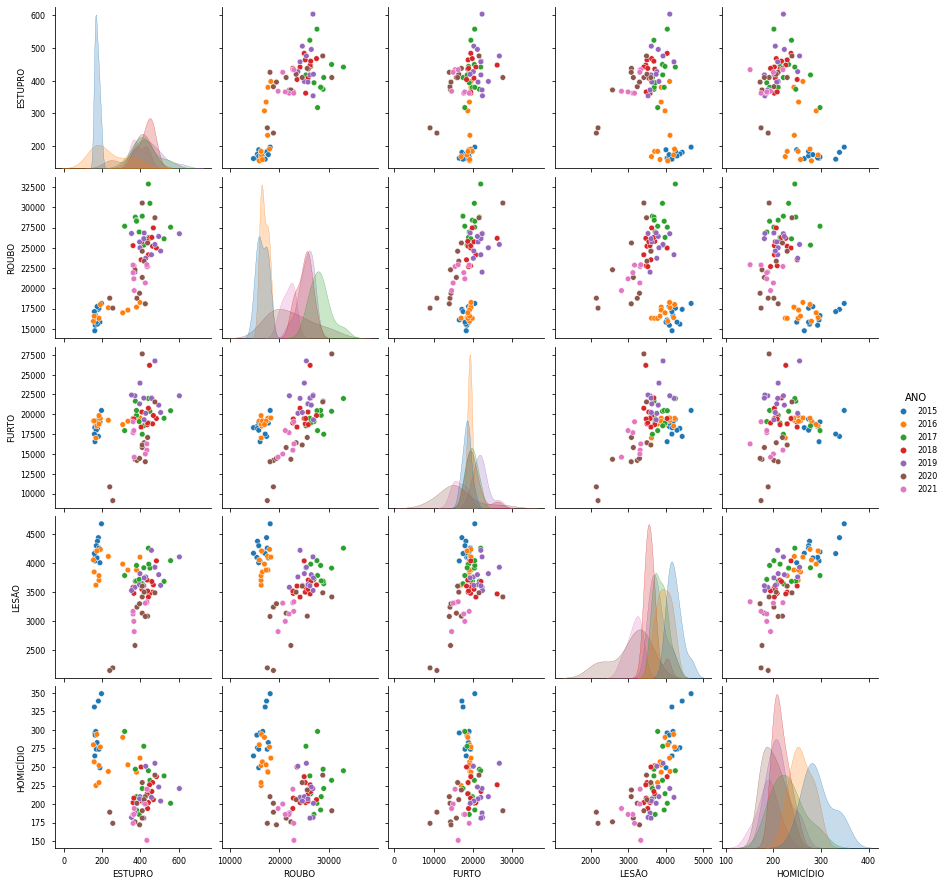

In [8]:
sns.pairplot(df_crime_consolidado, hue='ANO');

In [9]:
fig = ff.create_scatterplotmatrix(df_crime_consolidado, diag='box', index='ANO', height=1000, width=1000)
fig.write_html('../docs/crimes_scatter.html')
fig.show()

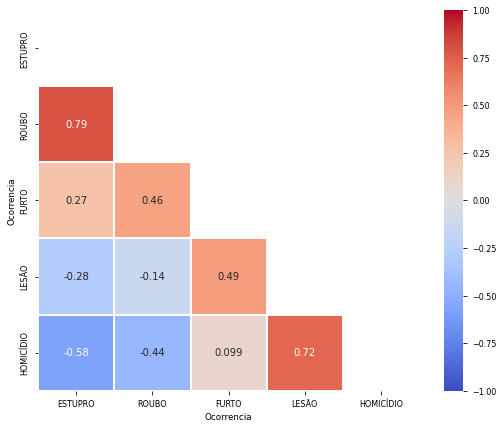

In [47]:
# corr = abs(df_crime_consolidado.corr())
corr = df_crime_consolidado.corr(method='pearson')

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(9, 7))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.05, vmin=-1, vmax=1, annot=True);

### Preliminar

Na matriz de correlação (de Pearson), obtemos correlações lineares fortes (acima de 0,6) para os pares:

- ROUBO vs ESTUPRO: 0,79
- HOMICÍDIO vs LESÃO: 0,72

Lembrando que a correlação não implica em causalidade.

# E sobre as ações policiais, será que alguma ação policial tem impacto sobre HOMICÍDIOS?

Antes de avançarmos para o modelo de regressão, vamos verificar se há atributos correlacionados e removermos eles.

In [88]:
# Criando df_produtividade_policial, que possui somente os atributos de ações policiais.

df_produtividade_policial = df[[
    'ANO', 'MES', 'Nº DE ARMAS DE FOGO APREENDIDAS', 'Nº DE FLAGRANTES LAVRADOS', 'Nº DE INFRATORES APREENDIDOS EM FLAGRANTE',
    'Nº DE INFRATORES APREENDIDOS POR MANDADO', 'Nº DE PESSOAS PRESAS EM FLAGRANTE', 'Nº DE PESSOAS PRESAS POR MANDADO',
    'Nº DE PRISÕES EFETUADAS', 'Nº DE VEÍCULOS RECUPERADOS', 'OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1)','OCORRÊNCIAS DE PORTE DE ENTORPECENTES',
    'OCORRÊNCIAS DE PORTE ILEGAL DE ARMA', 'OCORRÊNCIAS DE TRÁFICO DE ENTORPECENTES', 'TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS',]]

df_produtividade_policial.head()

Ocorrencia,ANO,MES,Nº DE ARMAS DE FOGO APREENDIDAS,Nº DE FLAGRANTES LAVRADOS,Nº DE INFRATORES APREENDIDOS EM FLAGRANTE,Nº DE INFRATORES APREENDIDOS POR MANDADO,Nº DE PESSOAS PRESAS EM FLAGRANTE,Nº DE PESSOAS PRESAS POR MANDADO,Nº DE PRISÕES EFETUADAS,Nº DE VEÍCULOS RECUPERADOS,OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1),OCORRÊNCIAS DE PORTE DE ENTORPECENTES,OCORRÊNCIAS DE PORTE ILEGAL DE ARMA,OCORRÊNCIAS DE TRÁFICO DE ENTORPECENTES,TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS
201501,2015,01,413,2223,245,27,2675,626,2528,3405,33,155,94,431,8323
201502,2015,02,363,2157,269,34,2591,586,2428,3188,51,241,109,506,8017
201503,2015,03,469,2605,319,54,3062,818,3026,3352,73,291,148,661,9523
201504,2015,04,392,2408,327,30,2895,871,2767,2952,68,335,125,627,7835
201505,2015,05,353,2530,352,55,3084,835,2941,3060,61,416,106,660,8532


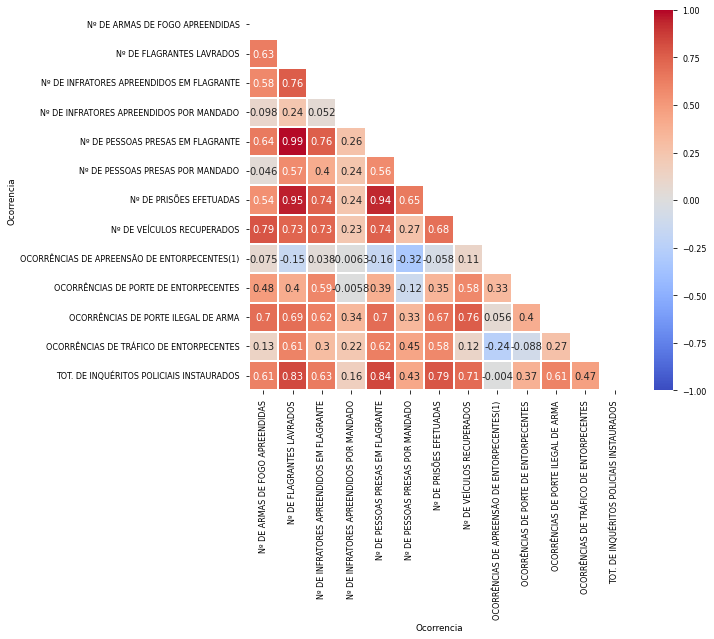

In [89]:
corr = df_produtividade_policial.corr(method='pearson')

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(9, 7))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.05, vmin=-1, vmax=1, annot=True);

In [90]:
corr_2d = corr.unstack().sort_values(kind='quicksort', ascending=False).abs()
corr_2d = pd.DataFrame(corr_2d[(corr_2d<1) & (corr_2d>0.75)])
corr_2d = corr_2d.drop_duplicates()
corr_2d

0
Ocorrencia                                Ocorrencia                                 
Nº DE PESSOAS PRESAS EM FLAGRANTE         Nº DE FLAGRANTES LAVRADOS          0.988703
Nº DE FLAGRANTES LAVRADOS                 Nº DE PRISÕES EFETUADAS            0.949396
Nº DE PRISÕES EFETUADAS                   Nº DE PESSOAS PRESAS EM FLAGRANTE  0.936202
TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS  Nº DE PESSOAS PRESAS EM FLAGRANTE  0.837870
                                          Nº DE FLAGRANTES LAVRADOS          0.833141
Nº DE VEÍCULOS RECUPERADOS                Nº DE ARMAS DE FOGO APREENDIDAS    0.789265
TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS  Nº DE PRISÕES EFETUADAS            0.788999
OCORRÊNCIAS DE PORTE ILEGAL DE ARMA       Nº DE VEÍCULOS RECUPERADOS         0.764995
Nº DE INFRATORES APREENDIDOS EM FLAGRANTE Nº DE FLAGRANTES LAVRADOS          0.764687
                                          Nº DE PESSOAS PRESAS EM FLAGRANTE  0.757424

**Comentário:** Os fatores com correlações muito fortes podem interferir negativamente no modelo de regressão e, portanto, é importante remover um dos atributos de cada par altamente correlacionado.

Abaixo, usaremos a biblioteca [feature engine](https://feature-engine.readthedocs.io/en/1.1.x/index.html) para acharmos e removermos os atributos em grupos com alta correlação.

In [91]:
feature_selection = DropCorrelatedFeatures(method='pearson', threshold=.75, missing_values='ignore')
df_produtividade_policial_selected = feature_selection.fit_transform(df_produtividade_policial)

print(f"""Grupo de variáveis correlacionadas (correlação de Pearson):
{feature_selection.correlated_feature_sets_}

Atributos que serão removidos:
{feature_selection.features_to_drop_}""")

Grupo de variáveis correlacionadas (correlação de Pearson):
[{'Nº DE ARMAS DE FOGO APREENDIDAS', 'Nº DE VEÍCULOS RECUPERADOS'}, {'Nº DE PESSOAS PRESAS EM FLAGRANTE', 'Nº DE PRISÕES EFETUADAS', 'TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS', 'Nº DE FLAGRANTES LAVRADOS', 'Nº DE INFRATORES APREENDIDOS EM FLAGRANTE'}]

Atributos que serão removidos:
{'Nº DE PESSOAS PRESAS EM FLAGRANTE', 'Nº DE PRISÕES EFETUADAS', 'TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS', 'Nº DE INFRATORES APREENDIDOS EM FLAGRANTE', 'Nº DE VEÍCULOS RECUPERADOS'}


Ocorrencia,ROUBO
201501,17400.0
201502,16095.0
201503,18133.0
201504,16636.0
201505,15438.0
...,...
202103,20660.0
202104,19723.0
202105,21934.0
202106,21173.0


In [98]:
df_merged = pd.concat([df_produtividade_policial_selected, df_crime_consolidado[['ROUBO']]], axis=1)
df_merged.head()

Ocorrencia,ANO,MES,Nº DE ARMAS DE FOGO APREENDIDAS,Nº DE FLAGRANTES LAVRADOS,Nº DE INFRATORES APREENDIDOS POR MANDADO,Nº DE PESSOAS PRESAS POR MANDADO,OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1),OCORRÊNCIAS DE PORTE DE ENTORPECENTES,OCORRÊNCIAS DE PORTE ILEGAL DE ARMA,OCORRÊNCIAS DE TRÁFICO DE ENTORPECENTES,ROUBO
201501,2015,01,413,2223,27,626,33,155,94,431,17400.0
201502,2015,02,363,2157,34,586,51,241,109,506,16095.0
201503,2015,03,469,2605,54,818,73,291,148,661,18133.0
201504,2015,04,392,2408,30,871,68,335,125,627,16636.0
201505,2015,05,353,2530,55,835,61,416,106,660,15438.0


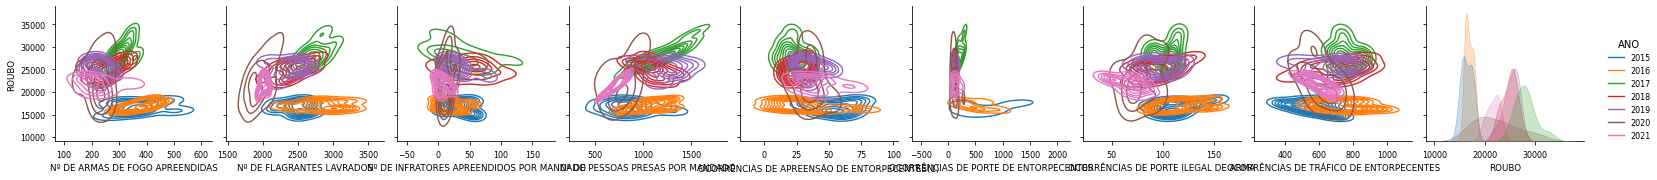

In [107]:
sns.pairplot(df_merged.drop(columns=['MES']), hue='ANO', y_vars=['ROUBO'], kind='kde');

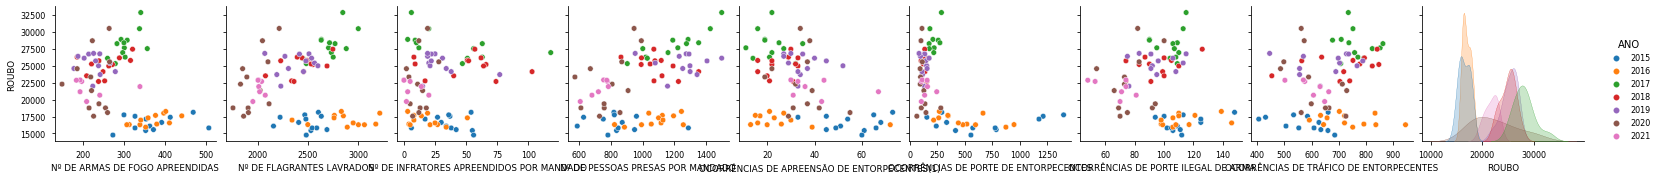

In [108]:
sns.pairplot(df_merged.drop(columns=['MES']), hue='ANO', y_vars=['ROUBO'], kind='scatter');

In [104]:
fig = ff.create_scatterplotmatrix(
    df_merged.drop(columns=['MES']), diag='box', index='ANO', height=1200, width=1200)

fig.write_html('../docs/roubo_scatter.html')
fig.show()